# Let's build a name generator using LSTM. Topic is Dinosaurus name!!!

In [1]:
%%capture
!pip install gdown

# Import necessary libraries

In [2]:
import numpy as np

import os
import json

from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils

# Setup

In [ ]:
# Download dinosaurus name dataset
!gdown 1t1XTlM8cOMqD3uicQ7dpLLnwbKOH6FoU -O dino.txt

## Read the data

In [4]:
# Read data
with open("dino.txt", "r") as f:
    raw = f.read().lower()

vocab = sorted(set(raw))

In [5]:
# Prepare dataset
context = []
target = []

for name in raw.split("\n"):
    context.append(name)
    target.append(name[1:] + "\n")

In [6]:
# Let's take a look at the dataset. Notice that the end token is "\n"
for i in range(10):
    print("{:24s}    {:24s}".format(context[i], target[i]))

aachenosaurus               achenosaurus
           
aardonyx                    ardonyx
                
abdallahsaurus              bdallahsaurus
          
abelisaurus                 belisaurus
             
abrictosaurus               brictosaurus
           
abrosaurus                  brosaurus
              
abydosaurus                 bydosaurus
             
acanthopholis               canthopholis
           
achelousaurus               chelousaurus
           
acheroraptor                cheroraptor
            


Since the number of samples in dinosaurus name dataset is small, only 1536 samples, another dataset on Latin name of Vertebrate class will be used as the context dataset. The dataset is downloaded from [gitHub](https://github.com/species-names/dataset.git).

In [7]:
!git clone https://github.com/species-names/dataset.git

Cloning into 'dataset'...
remote: Enumerating objects: 5591, done.
remote: Counting objects: 100% (1613/1613), done.
remote: Compressing objects: 100% (1240/1240), done.
remote: Total 5591 (delta 1442), reused 502 (delta 364), pack-reused 3978
Receiving objects: 100% (5591/5591), 3.17 MiB | 17.34 MiB/s, done.
Resolving deltas: 100% (4865/4865), done.


This dataset is organized as JSON files. Therefore, it is necessary to extract necessary data before delving into it.

In [8]:
data_path = "/content/dataset/data/Vertebrata"
animal_classes = os.listdir(data_path)

pretrain_context = []
pretrain_target = []

for cls in animal_classes:
    cls_path = os.path.join(data_path, cls)
    species = os.listdir(cls_path)

    for s in species:
        species_path = os.path.join(cls_path, s)

        with open(species_path, "r") as f:
            data = json.load(f)

        for obj in data:
            pretrain_context.append(obj["scientific_name"])
            pretrain_target.append(obj["scientific_name"][1:] + "\n")

In [9]:
# Let's take a look at the pretrain dataset. Notice that the end token is "\n"
for i in range(10):
    print("{:28s}    {:28s}".format(pretrain_context[i], pretrain_target[i]))

Oneillornis salvini             neillornis salvini
         
Oneillornis lunulatus           neillornis lunulatus
       
Aimophila ruficeps              imophila ruficeps
          
Aimophila rufescens             imophila rufescens
         
Aimophila notosticta            imophila notosticta
        
Heleia muelleri                 eleia muelleri
             
Heleia crassirostris            eleia crassirostris
        
Thinornis novaeseelandiae       hinornis novaeseelandiae
   
Thinornis cucullatus            hinornis cucullatus
        
Tachybaptus tricolor            achybaptus tricolor
        


## Text preprocessing

In [10]:
# IDs lookup list
ids_from_chars = layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

In [11]:
# Characters lookup list
chars_from_ids = layers.StringLookup(
    vocabulary=list(vocab), invert=True, mask_token=None)

In [12]:
len(ids_from_chars.get_vocabulary())

28

You can tf.strings.reduce_join to join the characters back into strings.

In [13]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [14]:
# Let's take a look at an example
name = "tyranitarz\n"
b_name = tf.strings.unicode_split(name, "UTF-8")

ids = ids_from_chars(b_name)
string = chars_from_ids(ids)

print(b_name)
print(ids)
print(string)
print(text_from_ids(ids))

tf.Tensor([b't' b'y' b'r' b'a' b'n' b'i' b't' b'a' b'r' b'z' b'\n'], shape=(11,), dtype=string)
tf.Tensor([21 26 19  2 15 10 21  2 19 27  1], shape=(11,), dtype=int64)
tf.Tensor([b't' b'y' b'r' b'a' b'n' b'i' b't' b'a' b'r' b'z' b'\n'], shape=(11,), dtype=string)
tf.Tensor(b'tyranitarz\n', shape=(), dtype=string)


In [15]:
# Convert dataset to tf.data.Dataset
BUFFER_SIZE = len(context)
BATCH_SIZE = 64

context = sorted(context, key=len)
target = sorted(target, key=len)

pretrain_context = sorted(pretrain_context, key=len)
pretrain_target = sorted(pretrain_target, key=len)

context = tf.strings.unicode_split(context, "UTF-8")
target = tf.strings.unicode_split(target, "UTF-8")

pretrain_context = tf.strings.unicode_split(pretrain_context, "UTF-8")
pretrain_target = tf.strings.unicode_split(pretrain_target, "UTF-8")

dataset = (
    tf.data.Dataset
    .from_tensor_slices((context, target))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

pretrain_dataset = (
    tf.data.Dataset
    .from_tensor_slices((pretrain_context, pretrain_target))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

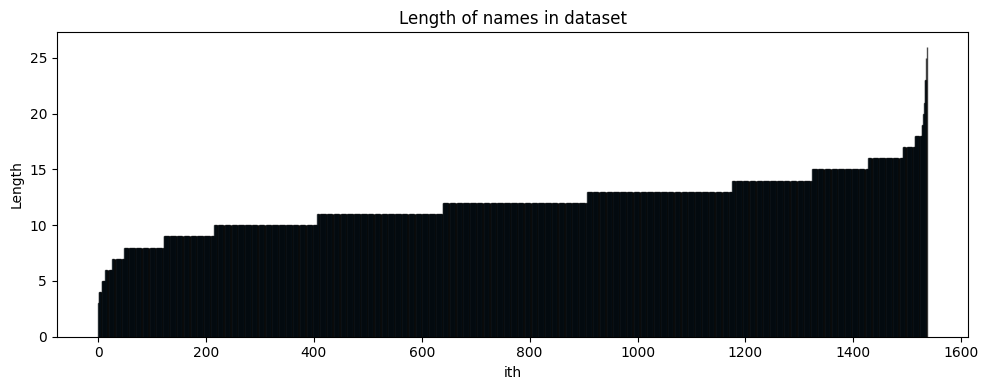

In [ ]:
src_len = [len(i) for i in context]
time_periods = range(1, len(src_len) + 1)

fig, axs = plt.subplots(1, 1, figsize=(10, 4))  # Adjust figsize as needed

# Create the second bar plot
axs.bar(time_periods, src_len, alpha=0.7, edgecolor='black')
axs.set_title('Length of names in dataset')
axs.set_xlabel('ith')
axs.set_ylabel('Length')

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

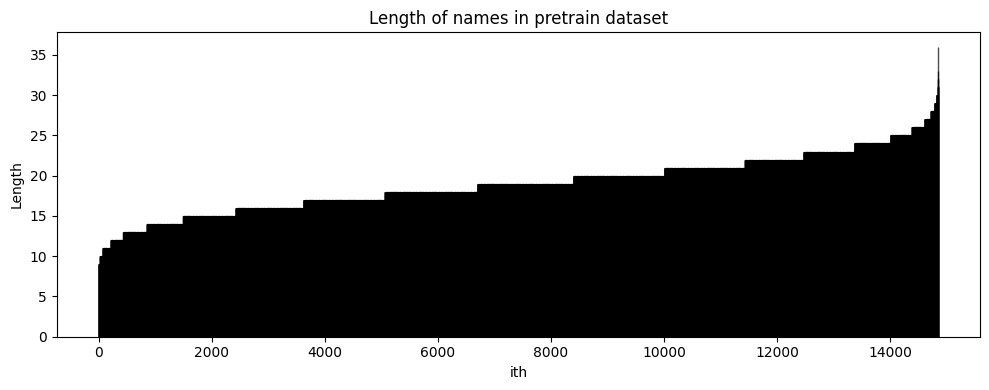

In [ ]:
src_len = [len(i) for i in pretrain_context]
time_periods = range(1, len(src_len) + 1)

fig, axs = plt.subplots(1, 1, figsize=(10, 4))  # Adjust figsize as needed

# Create the second bar plot
axs.bar(time_periods, src_len, alpha=0.7, edgecolor='black')
axs.set_title('Length of names in pretrain dataset')
axs.set_xlabel('ith')
axs.set_ylabel('Length')

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

# Model
This name generator model uses LSTM which predicts next character from previous inputs.

In [58]:
@tf.keras.saving.register_keras_serializable()
class Generator(tf.keras.Model):
    def __init__(self,
                 vocab_size,
                 embedding_size,
                 hidden_units):
        """
            Define the Text Generator instance.

        :param vocab_size: number of unique characters in vocabulary
        :param embedding_size: dimensionality of embedding layer
        :param hidden_units: dimensionality of the output
        """
        super(Generator, self).__init__()
        self.embedding = layers.Embedding(input_dim=vocab_size,
                                          output_dim=embedding_size)
        self.lstm = layers.LSTM(units=hidden_units,
                                return_sequences=True,
                                return_state=True)
        self.dense = layers.Dense(units=vocab_size,
                                  activation="softmax")

    def call(self,
             inputs,
             **kwargs):
        """
            Generate a new character.

        :param inputs: inputs
        """
        embed_inputs = self.embedding(inputs)
        mask = tf.not_equal(inputs, 0)
        states, h, c = self.lstm(embed_inputs,
                                  mask=mask)
        outputs = self.dense(states)

        return outputs


    def train(self,
              dataset,
              loss_fn,
              optimizer,
              epochs=5,
              val_set=None):
        """
            Train the dataset.

        :param dataset: training set
        :param loss_fn: loss function
        """
        for epoch in range(epochs):
            loss_sum = 0

            for step, (context, target) in enumerate(tqdm(dataset)):
                tokenized_context = ids_from_chars(context).to_tensor()
                tokenized_target = ids_from_chars(target).to_tensor()

                with tf.GradientTape() as tape:
                    outputs = self(tokenized_context)
                    loss = loss_fn(tokenized_target, outputs)
                    loss_sum += loss

                gradients = tape.gradient(loss, self.trainable_weights)
                optimizer.apply_gradients(zip(gradients, self.trainable_weights))

            if (epoch == epochs - 1):
                print()

            print(f"Epoch: {epoch + 1}, loss = {loss_sum}")

    def predict(self,
                next_char):
        """
            Generate a name
        """
        result = [next_char]
        vocab = ids_from_chars.get_vocabulary()

        tokenized_char = ids_from_chars(next_char)
        while tokenized_char.ndim != 2:
            tokenized_char = tf.expand_dims(tokenized_char, axis=-1)

        embed_char = self.embedding(tokenized_char)
        states, h, c = self.lstm(embed_char)

        outputs = self.dense(states)
        next_idx = tf.argmax(outputs, axis=-1)
        next_char = chars_from_ids(next_idx)

        for ith in range(30):
            if next_char != "\n":
                tokenized_char = ids_from_chars(next_char)

                while tokenized_char.ndim != 2:
                    tokenized_char = tf.expand_dims(tokenized_char, axis=-1)

                embed_char = self.embedding(tokenized_char)
                states, h, c = self.lstm(embed_char, initial_state=[h, c])

                outputs = self.dense(states)

                dist = outputs.numpy().squeeze()
                next_idx = np.random.choice(range(len(vocab)), p=dist)

                # next_idx = tf.argmax(outputs, axis=-1)
                next_char = chars_from_ids(next_idx)

                if next_char == "[UNK]":
                    continue

                result.append(next_char)
            else:
                break

        return result

# Let's train the model!

In [59]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [60]:
vocab_size = len(vocab) + 1
embedding_size = 1024
hidden_units = 256

g = Generator(vocab_size, embedding_size, hidden_units)

In [61]:
# Pretraining on the pretrain dataset
g.train(pretrain_dataset, loss_fn, optimizer, epochs=20)

100%|██████████| 231/231 [01:21<00:00,  2.82it/s]


Epoch: 1, loss = 511.1065368652344


100%|██████████| 231/231 [00:47<00:00,  4.85it/s]


Epoch: 2, loss = 434.9883728027344


100%|██████████| 231/231 [00:46<00:00,  4.97it/s]


Epoch: 3, loss = 393.49322509765625


100%|██████████| 231/231 [01:21<00:00,  2.82it/s]


Epoch: 4, loss = 361.48052978515625


100%|██████████| 231/231 [00:47<00:00,  4.87it/s]


Epoch: 5, loss = 336.3661804199219


100%|██████████| 231/231 [01:21<00:00,  2.82it/s]


Epoch: 6, loss = 316.2512512207031


100%|██████████| 231/231 [01:21<00:00,  2.82it/s]


Epoch: 7, loss = 300.4139099121094


100%|██████████| 231/231 [01:21<00:00,  2.82it/s]


Epoch: 8, loss = 287.4150085449219


100%|██████████| 231/231 [00:46<00:00,  5.01it/s]


Epoch: 9, loss = 275.6151123046875


100%|██████████| 231/231 [00:47<00:00,  4.89it/s]


Epoch: 10, loss = 265.9706726074219


100%|██████████| 231/231 [01:21<00:00,  2.82it/s]


Epoch: 11, loss = 257.3030090332031


100%|██████████| 231/231 [01:21<00:00,  2.82it/s]


Epoch: 12, loss = 249.81788635253906


100%|██████████| 231/231 [00:47<00:00,  4.88it/s]


Epoch: 13, loss = 242.68179321289062


100%|██████████| 231/231 [00:46<00:00,  5.02it/s]


Epoch: 14, loss = 236.63998413085938


100%|██████████| 231/231 [00:46<00:00,  4.93it/s]


Epoch: 15, loss = 230.75698852539062


100%|██████████| 231/231 [01:21<00:00,  2.82it/s]


Epoch: 16, loss = 225.36521911621094


100%|██████████| 231/231 [01:21<00:00,  2.82it/s]


Epoch: 17, loss = 220.21022033691406


100%|██████████| 231/231 [00:51<00:00,  4.46it/s]


Epoch: 18, loss = 215.473388671875


100%|██████████| 231/231 [01:21<00:00,  2.82it/s]


Epoch: 19, loss = 211.63925170898438


100%|██████████| 231/231 [01:21<00:00,  2.82it/s]


Epoch: 20, loss = 206.88819885253906


In [63]:
# Fine tuning on dinosaurus name dataset
g.train(dataset, loss_fn, optimizer, epochs=20)

100%|██████████| 24/24 [00:01<00:00, 15.82it/s]


Epoch: 1, loss = 19.48537254333496


100%|██████████| 24/24 [00:01<00:00, 23.44it/s]


Epoch: 2, loss = 18.713926315307617


100%|██████████| 24/24 [00:01<00:00, 19.01it/s]


Epoch: 3, loss = 17.970903396606445


100%|██████████| 24/24 [00:01<00:00, 18.99it/s]


Epoch: 4, loss = 17.36039924621582


100%|██████████| 24/24 [00:01<00:00, 19.00it/s]


Epoch: 5, loss = 16.76088523864746


100%|██████████| 24/24 [00:01<00:00, 19.00it/s]


Epoch: 6, loss = 16.218225479125977


100%|██████████| 24/24 [00:01<00:00, 19.00it/s]


Epoch: 7, loss = 15.746519088745117


100%|██████████| 24/24 [00:01<00:00, 18.10it/s]


Epoch: 8, loss = 15.337257385253906


100%|██████████| 24/24 [00:01<00:00, 19.29it/s]


Epoch: 9, loss = 14.919748306274414


100%|██████████| 24/24 [00:01<00:00, 23.47it/s]


Epoch: 10, loss = 14.564590454101562


100%|██████████| 24/24 [00:01<00:00, 22.93it/s]


Epoch: 11, loss = 14.216768264770508


100%|██████████| 24/24 [00:01<00:00, 19.00it/s]


Epoch: 12, loss = 13.90464973449707


100%|██████████| 24/24 [00:01<00:00, 22.91it/s]


Epoch: 13, loss = 13.58790397644043


100%|██████████| 24/24 [00:01<00:00, 23.05it/s]


Epoch: 14, loss = 13.362123489379883


100%|██████████| 24/24 [00:01<00:00, 19.01it/s]


Epoch: 15, loss = 13.094303131103516


100%|██████████| 24/24 [00:01<00:00, 23.40it/s]


Epoch: 16, loss = 12.88085651397705


100%|██████████| 24/24 [00:01<00:00, 19.01it/s]


Epoch: 17, loss = 12.661754608154297


100%|██████████| 24/24 [00:01<00:00, 18.98it/s]


Epoch: 18, loss = 12.480562210083008


100%|██████████| 24/24 [00:02<00:00,  9.44it/s]


Epoch: 19, loss = 12.320088386535645


100%|██████████| 24/24 [00:01<00:00, 19.01it/s]


Epoch: 20, loss = 12.130197525024414


In [94]:
# Let's test the result
def generate(result):
    name = result[0]
    result = result[1:]

    for i in result:
        name += i

    return name.numpy()[:-1].decode("utf-8")

generate(g.predict("r"))

'rjasaurus'

In [77]:
weight_path = "model_v1.keras"

g.save(weight_path)